In [7]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc, plot_confusion_matrix, matthews_corrcoef, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

In [2]:
## Read the best hyperparameters (Bayesian hyperparameter optimization need to be done for this!)
def read_param():
    f0 = open('datasets/best-paramters_et_optuna_TPE.txt','r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = int(b[1][1]); p2 = int(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = float(b[5][1]); p6 = int(b[6][1])
    return p1, p2, p3, p4, p5, p6

In [4]:
data = pd.read_csv('datasets/final_elem+hard-feat_data_cls_com.csv') ## obtained after mean feature ranking
X = data.iloc[:,1:-1]
Y = data.iloc[:,-1]

In [8]:
p1, p2, p3, p4, p5, p6 = read_param()

test_size = 0.1
random = 129 ## random state counter for train-test split; obtain after checking with 200 random train-test splits
random_sm = 0 ## random state counter for SMOTE; obtain after checking with 200 random train-test splits

## oversampling to be done before training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random, stratify=Y)
dict = {2:100, 6:100}  ## oversample the Hl and Lh class
oversample = SMOTE(sampling_strategy=dict, random_state=random_sm)
x_train_sm, y_train_sm = oversample.fit_resample(X_train, Y_train)

### =============================================================================
###                              ML (ET) MODEL
### =============================================================================
weights = {0:3.0, 1:1.0, 2:3.0, 3:3.0, 4:0.8, 5:1.0, 6:3.0, 7:1.6, 8:1.9} # --> best one till now
params = {"class_weight": weights, "n_estimators": p1, "max_depth": p2, "criterion": "entropy",
          'min_samples_leaf': p3, 'min_samples_split': p4, 'min_weight_fraction_leaf': p5, "random_state": p6 
          }
et = ExtraTreesClassifier(**params)
et.fit(x_train_sm, y_train_sm)

Y_pred_test = et.predict(X_test)
Y_pred_train = et.predict(x_train_sm)

#####---------------------- VALUES OF DIFFERENT PARAMS ---------------------------------
acc_test = accuracy_score(Y_test,Y_pred_test)
acc_train = accuracy_score(y_train_sm,Y_pred_train)
print("Accuracy train:  ", acc_train)    
print("Accuracy test:  ", acc_test)
   
#f1_test=f1_score(Y_test,Y_pred_test,average='micro')
f1_test = f1_score(Y_test,Y_pred_test,average='weighted')
f1_train = f1_score(y_train_sm,Y_pred_train,average='weighted')
print("F1 train:  ", f1_train)
print("F1 test:  ",  f1_test)

prec_test = precision_score(Y_test,Y_pred_test,average='weighted')
prec_train = precision_score(y_train_sm,Y_pred_train,average='weighted')
print("Precision train:  ", prec_train)           # test_data, vicker_test 
print("Precision test:  ", prec_test)

mcc_test = matthews_corrcoef(Y_test,Y_pred_test)
mcc_train = matthews_corrcoef(y_train_sm,Y_pred_train)
print("MCC train:  ", mcc_train)    
print("MCC test:  ", mcc_test)

Accuracy train:   0.8673260572987722
Accuracy test:   0.7161290322580646
F1 train:   0.8671284601497206
F1 test:   0.706225250297734
Precision train:   0.8779731231490979
Precision test:   0.7136915714181561
MCC train:   0.8226244570888909
MCC test:   0.5862466327325687


0.985101854667072
0.9168894168894169
0.9659016393442623
0.6636158192090396
0.8614545605928147
0.9067028985507246
0.970873786407767
0.9500075746099076
0.9609332609875203


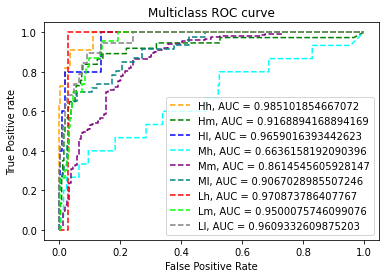

In [10]:
# =============================================================================
#          ROC-AUC Curves
# =============================================================================
target_names = ['Hh', 'Hm', 'Hl', 'Mh', 'Mm', 'Ml', 'Lh', 'Lm', 'Ll']
pred = Y_pred_test
pred_prob = et.predict_proba(X_test)

fpr = {}
tpr = {}
auc_score = {}
thresh = {}

n_class = 9

colors = ['orange', 'green', 'blue', 'cyan', 'purple', 'teal', 'red', 'lime', 'grey']
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, pred_prob[:,i], pos_label=i)
    auc_score[i] = auc(fpr[i], tpr[i]) 
    print(auc_score[i])
    label = target_names[i] + ', AUC = ' + str(auc_score[i])
    plt.plot(fpr[i], tpr[i], linestyle='--', color=colors[i], label=label)

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()
#plt.savefig('roc_et_mcc.png', dpi=300)

[[ 108    2    2    1    1    0    0    0    0]
 [  38  239   15   11   60    3    0    0    0]
 [   0    1   53    1    0    0    0    0    0]
 [   1    0    1  137   11    1    1    2    0]
 [   9   19    4   51 1373   32    0   28    9]
 [   1    6   12    5   65  350    0    4   13]
 [   0    0    0    0    0    0    7    1    0]
 [   0    0    0    2    6    1    4  194   22]
 [   0    0    0    0    3    2    1   25  161]]


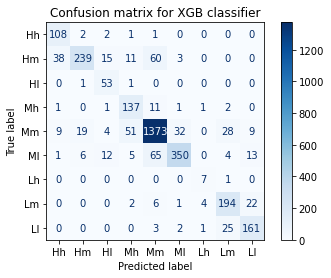

In [11]:
# =============================================================================
#         Confusion Matrix
# =============================================================================
title = 'Confusion matrix for XGB classifier'
# cm = confusion_matrix(y_test, y_pred_test)
Y_pred = et.predict(X)
cm = confusion_matrix(Y, Y_pred)
print(cm)
disp = plot_confusion_matrix(et,
                             X,
                             Y,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)
plt.show()
#plt.savefig('cm_et_mcc.png', dpi=300)

In [12]:
# =============================================================================
#                             Classification report
# =============================================================================
report = classification_report(Y, Y_pred)
print("Classification report:-")
print(report)

Classification report:-
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       114
           1       0.90      0.65      0.76       366
           2       0.61      0.96      0.75        55
           3       0.66      0.89      0.76       154
           4       0.90      0.90      0.90      1525
           5       0.90      0.77      0.83       456
           6       0.54      0.88      0.67         8
           7       0.76      0.85      0.80       229
           8       0.79      0.84      0.81       192

    accuracy                           0.85      3099
   macro avg       0.75      0.85      0.79      3099
weighted avg       0.86      0.85      0.85      3099

